# Die [Titanic challenge](https://www.kaggle.com/c/titanic)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
sns.set()

%matplotlib inline

data = pd.read_csv('../data/train.csv')

Let's see how the data looks like

In [2]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We don't need PassengerId as an input to the model.
And have a quick look at data stats

In [3]:
data.drop('PassengerId', axis=1, inplace=True)
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Check if the gender plays a role in survival

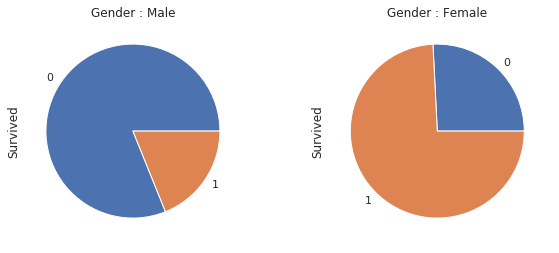

In [4]:
fig = plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.title('Gender : Male')
data.Survived[data['Sex'] == 'male'].value_counts().sort_index().plot(kind='pie')
fig.add_subplot(122)
plt.title('Gender : Female')
data.Survived[data['Sex'] == 'female'].value_counts().sort_index().plot(kind='pie')

In [5]:
from sklearn.preprocessing import LabelEncoder
data['Sex'] = LabelEncoder().fit_transform(data['Sex'])

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['Sex']], data['Survived'], test_size=0.2, random_state=42)

decision_tree_clf = DecisionTreeClassifier()
decision_tree_clf.fit(X_train, y_train)
score = decision_tree_clf.score(X_test, y_test)
print(score.round(2))

0.78


Split the titles from the passenger names which is itself a feature but also help in calculating missing median age values

In [7]:
data['Name'] = data['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
titles = data['Name'].unique()
titles

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [8]:
data['Age'].fillna(-1, inplace=True)

medians = dict()
for title in titles:
    median = data.Age[(data["Age"] != -1) & (data['Name'] == title)].median()
    medians[title] = median
    
for index, row in data.iterrows():
    if row['Age'] == -1:
        data.loc[index, 'Age'] = medians[row['Name']]

data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,Mr,1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,Mrs,0,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,Miss,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,Mrs,0,35.0,1,0,113803,53.1000,C123,S
4,0,3,Mr,1,35.0,0,0,373450,8.0500,NaN,S


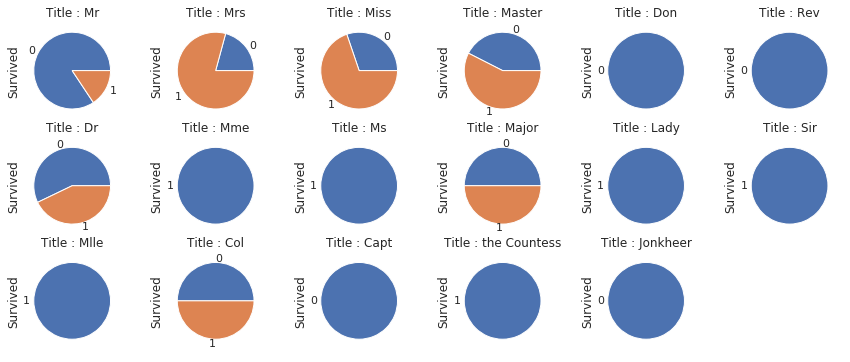

In [9]:
fig = plt.figure(figsize=(15,6))

i=1
for title in data['Name'].unique():
    fig.add_subplot(3, 6, i)
    plt.title('Title : {}'.format(title))
    data.Survived[data['Name'] == title].value_counts().sort_index().plot(kind='pie')
    i += 1

Transform the titles to numeric values such that the magnitude has a somewhat linear relationship with survival
Alongwith transformation, the values need to be scaled down since some models like Neural nets are very sensitive to data which is not properly scaled

In [10]:
replacement = {
    'Don': 0,
    'Rev': 0,
    'Jonkheer': 0,
    'Capt': 0,
    'Mr': 1,
    'Dr': 2,
    'Col': 3,
    'Major': 3,
    'Master': 4,
    'Miss': 5,
    'Mrs': 6,
    'Mme': 7,
    'Ms': 7,
    'Mlle': 7,
    'Sir': 7,
    'Lady': 7,
    'the Countess': 7
}

data['Name'] = data['Name'].apply(lambda x: replacement.get(x))

from sklearn.preprocessing import StandardScaler
data['Name'] = StandardScaler().fit_transform(data['Name'].values.reshape(-1, 1))

In [11]:
data.head()[['Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']]

,Pclass,Age,SibSp,Parch,Ticket,Cabin,Embarked
0,3,22.0,1,0,A/5 21171,NaN,S
1,1,38.0,1,0,PC 17599,C85,C
2,3,26.0,0,0,STON/O2. 3101282,NaN,S
3,1,35.0,1,0,113803,C123,S
4,3,35.0,0,0,373450,NaN,S


In [12]:
data['Age'] = StandardScaler().fit_transform(data['Age'].values.reshape(-1, 1))

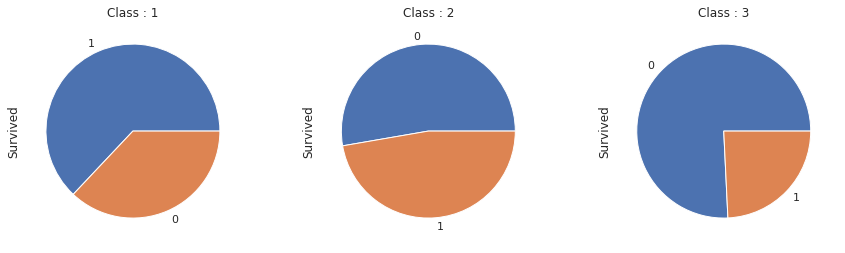

In [13]:
fig = plt.figure(figsize=(15,4))

i=1
for pclass in sorted(data['Pclass'].unique()):
    fig.add_subplot(1, 3, i)
    plt.title('Class : {}'.format(pclass))
    data.Survived[data['Pclass'] == pclass].value_counts().plot(kind='pie')
    i += 1

In [14]:
data['Pclass'] = StandardScaler().fit_transform(data['Pclass'].values.reshape(-1, 1))

In [15]:
data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

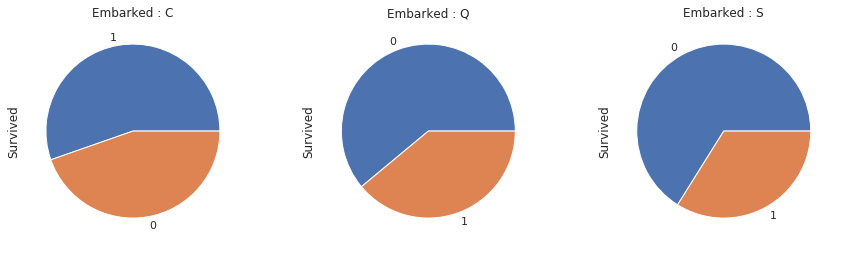

In [16]:
data['Embarked'].fillna('S', inplace=True)
fig = plt.figure(figsize=(15,4))
i = 1
for embarked in sorted(data['Embarked'].unique()):
    fig.add_subplot(1, 3, i)
    plt.title('Embarked : {}'.format(embarked))
    data.Survived[data['Embarked'] == embarked].value_counts().plot(kind='pie')
    i += 1

In [17]:
replacement = {
    'S': 0,
    'Q': 1,
    'C': 2
}

data['Embarked'] = data['Embarked'].apply(lambda x: replacement.get(x))
data['Embarked'] = StandardScaler().fit_transform(data['Embarked'].values.reshape(-1, 1))
data.head()['Embarked']

0   -0.585954
1    1.942303
2   -0.585954
3   -0.585954
4   -0.585954
Name: Embarked, dtype: float64

In [18]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0.827377,-0.797294,1,-0.557420,1,0,A/5 21171,7.2500,NaN,-0.585954
1,1,-1.566107,1.537975,0,0.649410,1,0,PC 17599,71.2833,C85,1.942303
2,1,0.827377,1.070922,0,-0.255712,0,0,STON/O2. 3101282,7.9250,NaN,-0.585954
3,1,-1.566107,1.537975,0,0.423129,1,0,113803,53.1000,C123,-0.585954
4,0,0.827377,-0.797294,1,0.423129,0,0,373450,8.0500,NaN,-0.585954


In [19]:
data = data.drop(['SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin'], axis=1)

In [20]:
from sklearn.model_selection import train_test_split
survived = data['Survived']
data.drop('Survived', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data, survived, test_size=0.2, random_state=42)

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

models = [
    [ "Random Forest", RandomForestClassifier(n_estimators=100)],
    [ "Decision Tree", DecisionTreeClassifier()],
    [ "MLP", MLPClassifier()],
    [ "k Neighbours", KNeighborsClassifier()],
    [ "Support Vector Machine", SVC()],
    [ "Gaussian Process", GaussianProcessClassifier()],
    [ "Ada Boost", AdaBoostClassifier()],
    [ "Gaussian DB", GaussianNB()],
    [ "Quadratic Discriminant Analysis", QuadraticDiscriminantAnalysis()],    
]

from sklearn.metrics import accuracy_score

for name, model in models:
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print("%.2f" % score.round(2), name)

0.82 Random Forest
0.79 Decision Tree
0.82 MLP
0.81 k Neighbours
0.82 Support Vector Machine
0.80 Gaussian Process
0.82 Ada Boost
0.79 Gaussian DB
0.79 Quadratic Discriminant Analysis
